In [2]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import SimpleRNN,Dropout

In [3]:
df = pd.read_csv('AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df.Datetime,errors='coerce')
print(type(df['Datetime']))
df

<class 'pandas.core.series.Series'>


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


<AxesSubplot:title={'center':'AEP'}, xlabel='Datetime'>

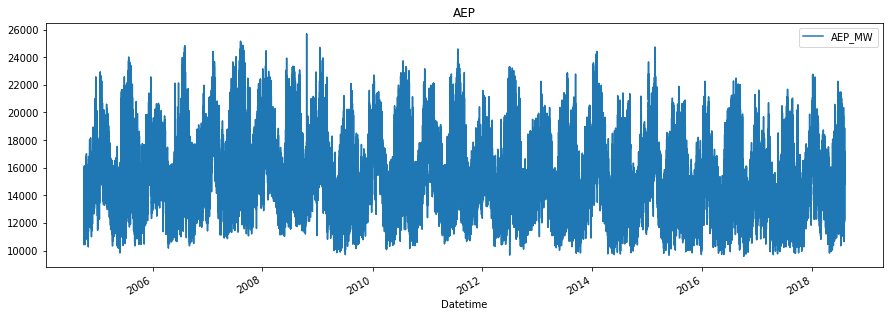

In [4]:
df = pd.read_csv('AEP_hourly.csv', index_col=[0],parse_dates=[0])
df_s = pd.read_csv('AEP_hourly.csv',parse_dates=[0])
df.plot(figsize=(15,5),  title='AEP')

In [5]:
def create_features(df):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    x = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    return x

df1= create_features(df)
df1['AEP_MW'] = df['AEP_MW']
df1

C:\Users\ALI~1.SAG\AppData\Local\Temp/ipykernel_7028/3369198571.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,AEP_MW
Datetime,,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,53,13478.0
2004-12-31 02:00:00,2,4,4,12,2004,366,31,53,12865.0
2004-12-31 03:00:00,3,4,4,12,2004,366,31,53,12577.0
2004-12-31 04:00:00,4,4,4,12,2004,366,31,53,12517.0
2004-12-31 05:00:00,5,4,4,12,2004,366,31,53,12670.0
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,21089.0
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,20999.0
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,20820.0


<AxesSubplot:xlabel='Datetime'>

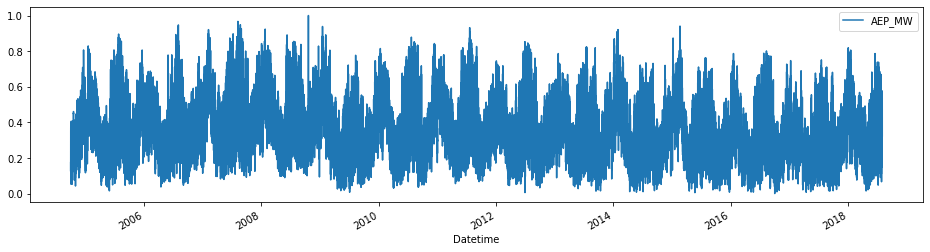

In [6]:
df= pd.read_csv('AEP_hourly.csv',index_col='Datetime',parse_dates=['Datetime'])
df= pd.read_csv('AEP_hourly.csv',index_col='Datetime',parse_dates=['Datetime'])

scaler = MinMaxScaler()
df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))

df.plot(figsize=(16,4),legend=True)

In [7]:
def load_data(df, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(df)):
        X_train.append(df.iloc[i - seq_len: i, 0])
        y_train.append(df.iloc[i, 0])

    X_test = X_train[110000:]
    y_test = y_train[110000:]

    X_train = X_train[:110000]
    y_train = y_train[:110000]

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_train = np.reshape(X_train, (110000, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [8]:
seq_len = 30

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 30, 1)
y_train.shape =  (110000,)
X_test.shape =  (11243, 30, 1)
y_test.shape =  (11243,)


# RNN

In [44]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.10))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True))
rnn_model.add(Dropout(0.10))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=False))
rnn_model.add(Dropout(0.1))

rnn_model.add(Dense(1))

rnn_model.summary()

rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 30, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 30, 40)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 30, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 40)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [9]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.10))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True))
rnn_model.add(Dropout(0.10))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True))
rnn_model.add(Dropout(0.1))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=False))
rnn_model.add(Dropout(0.1))

rnn_model.add(Dense(1))

rnn_model.summary()

rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 30, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 30, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 30, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3

In [10]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9558109544073038


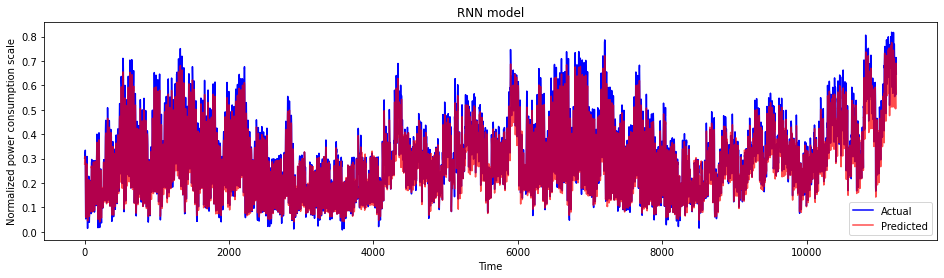

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(rnn_predictions, alpha=0.7, color='red', label='Predicted')
plt.title("RNN model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

# LSTM

In [11]:
LSTM_model = Sequential()

LSTM_model.add(LSTM(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
LSTM_model.add(Dropout(0.10))

LSTM_model.add(LSTM(40,activation="relu",return_sequences=True))
LSTM_model.add(Dropout(0.10))

LSTM_model.add(LSTM(40,activation="relu",return_sequences=False))
LSTM_model.add(Dropout(0.10))

LSTM_model.add(Dense(1))

LSTM_model.summary()

LSTM_model.compile(optimizer="adam",loss="MSE")
LSTM_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 40)            6720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 40)            12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [12]:
LSTM_predictions = LSTM_model.predict(X_test)

LSTM_score = r2_score(y_test,LSTM_predictions)
print("R2 Score of LSTM model = ",LSTM_score)

R2 Score of LSTM model =  0.9356762165425201


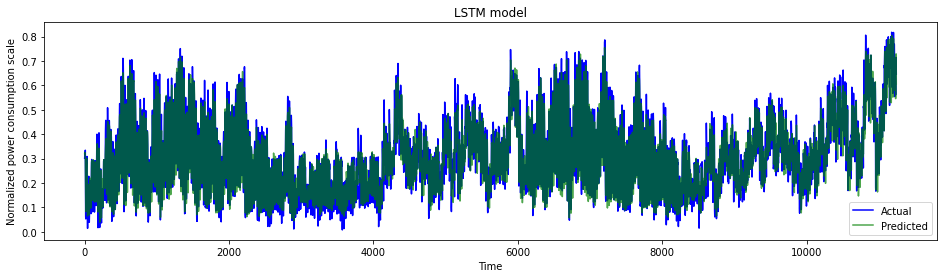

In [17]:
plt.figure(figsize=(16, 4))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(LSTM_predictions, alpha=0.7, color='green', label='Predicted')
plt.title("LSTM model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()